<a href="https://colab.research.google.com/github/Vedant-Mahadik/DesignOptimizationFall2022/blob/main/Project01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MAE 598 : Design Optimization**

Project 01 - Gradient-based Algorithm and Differentiable Programming  (Rocket Landing)

Name - Vedant Rajesh Mahadik

ASU ID - 1222505193 

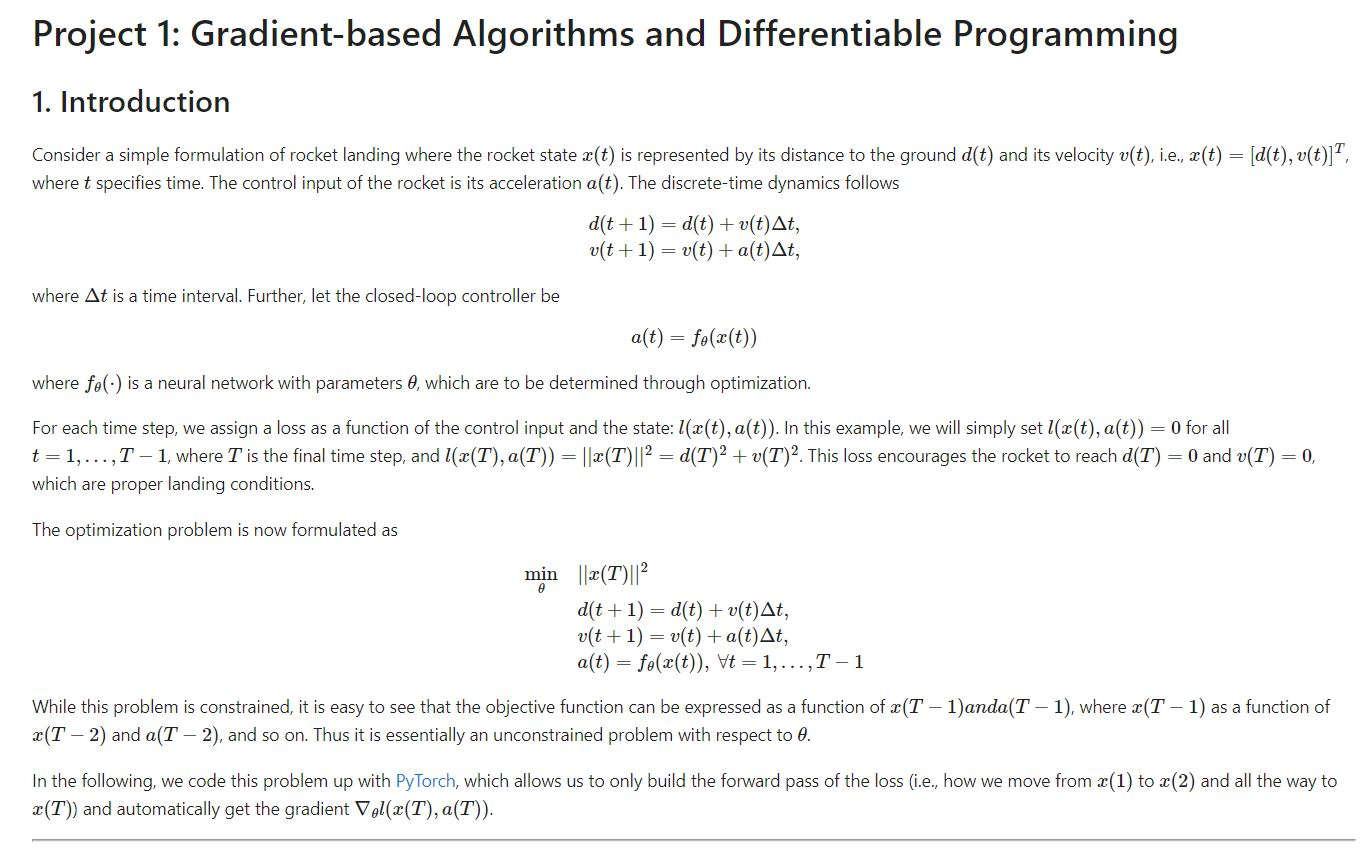

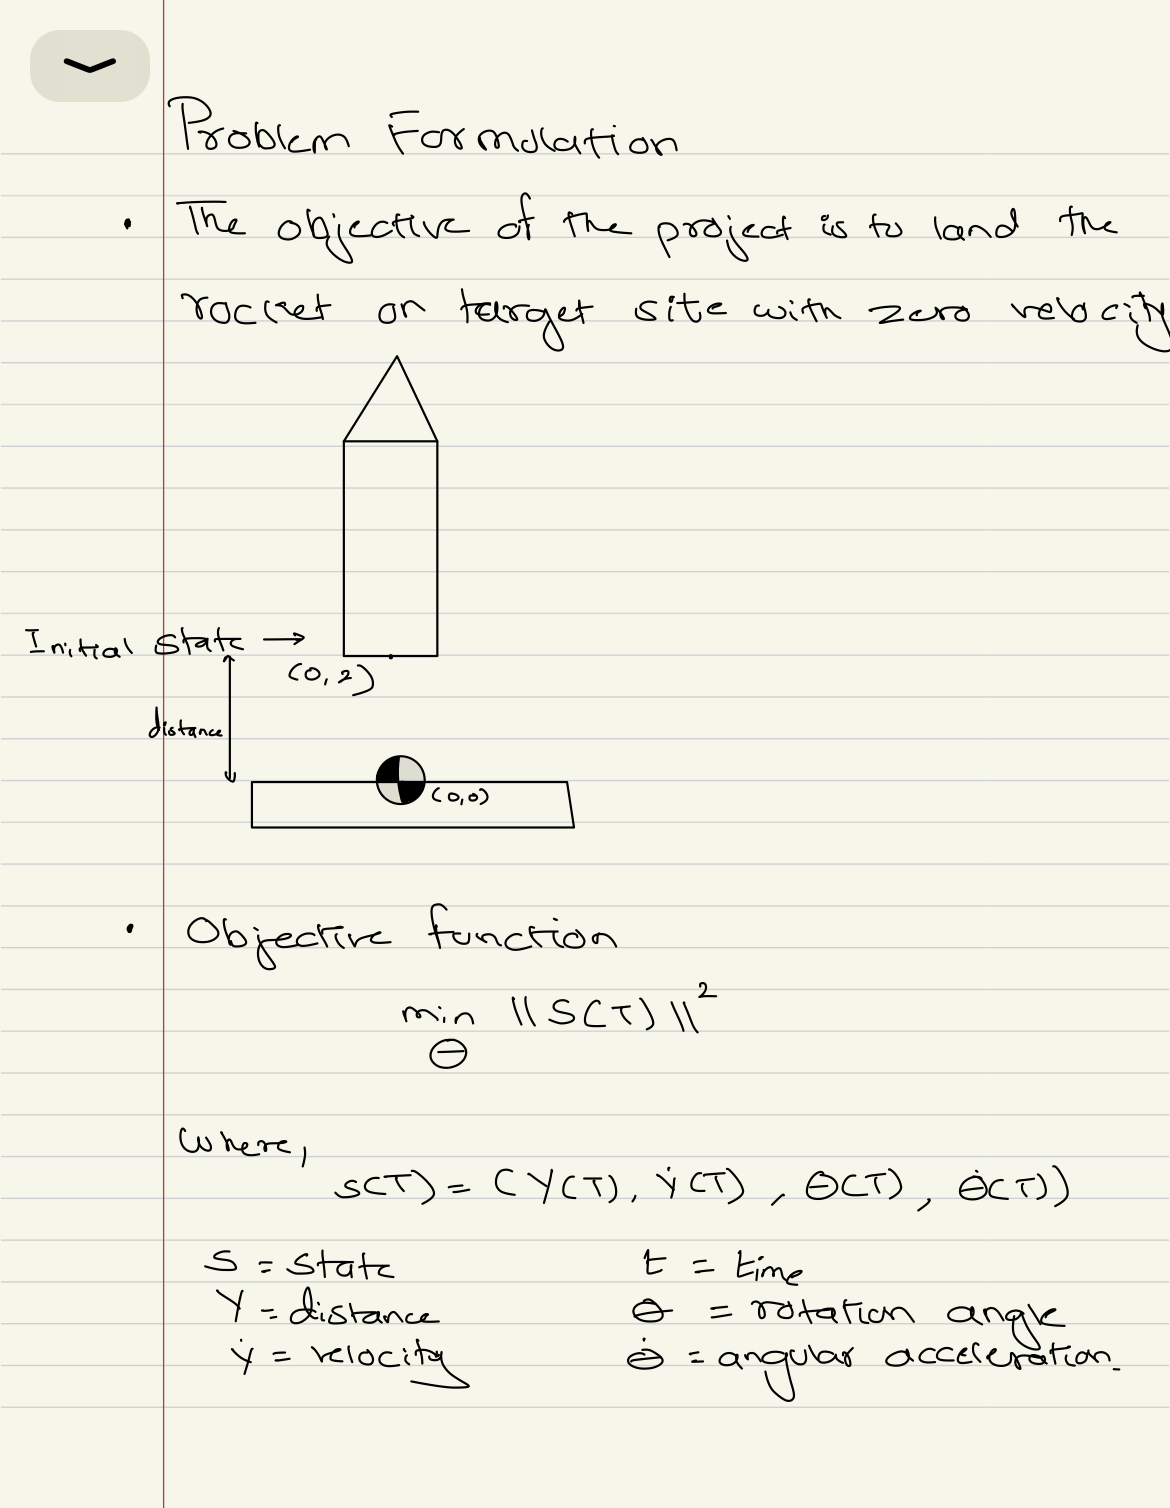

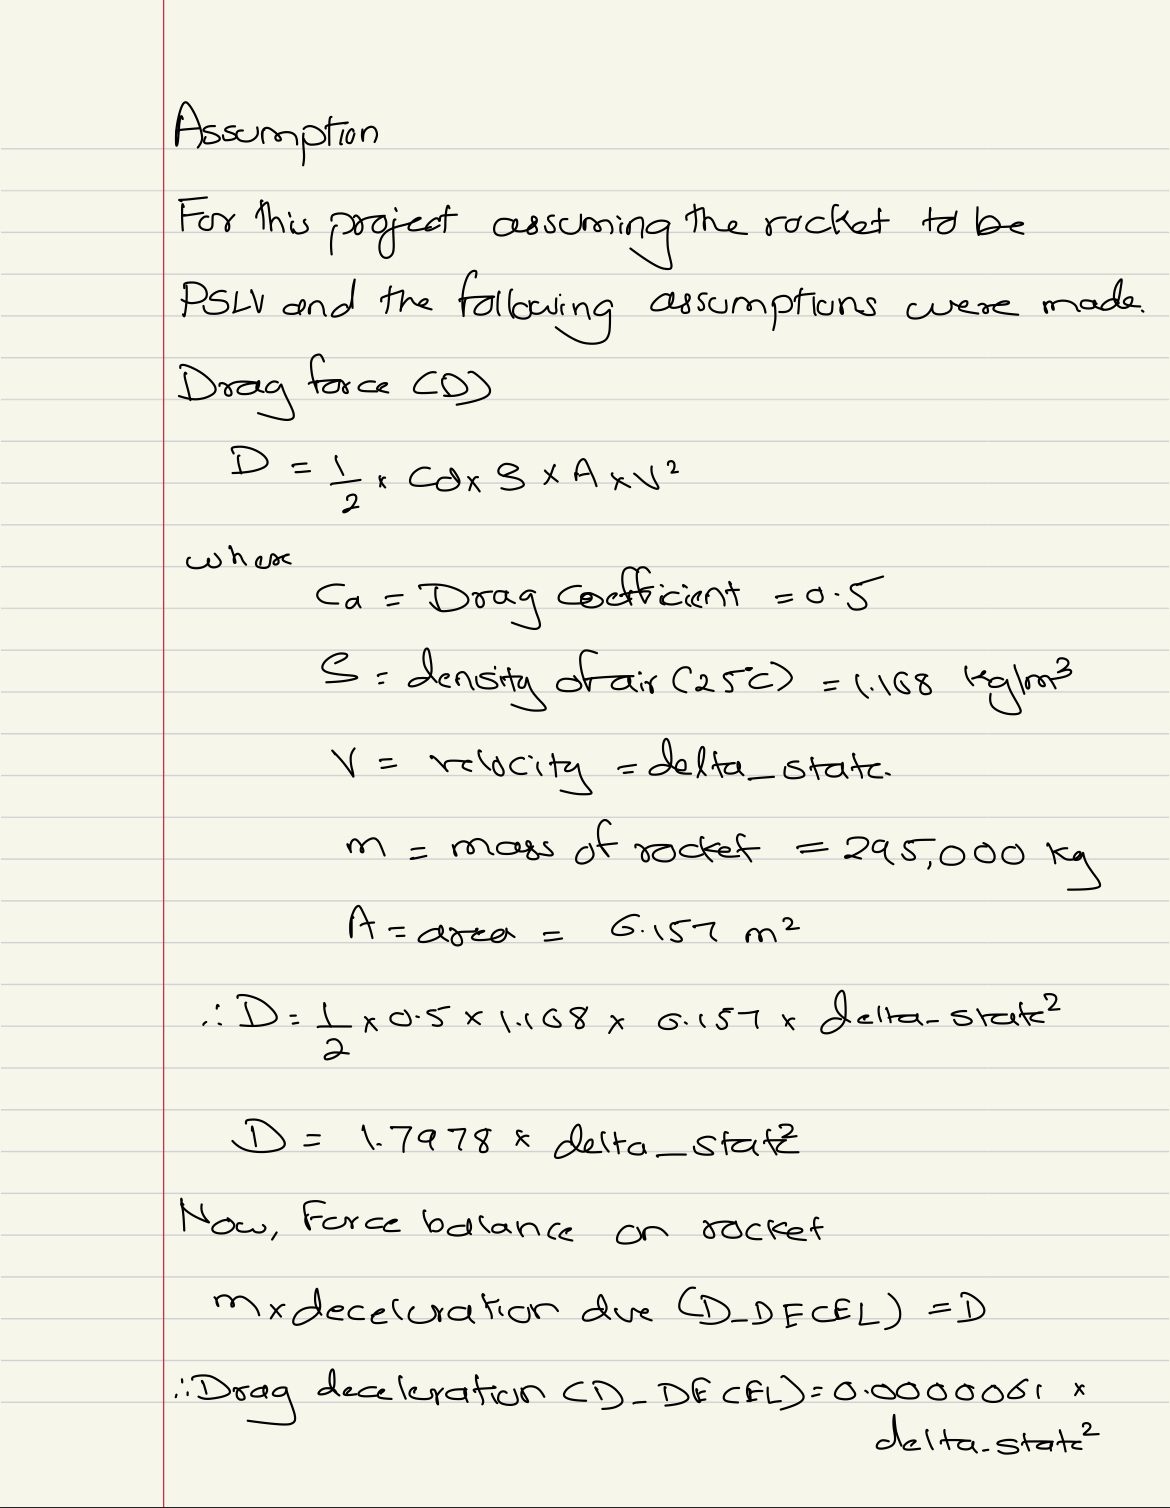

In [2]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

logger = logging.getLogger(__name__)

In [3]:
# environment parameters

FRAME_TIME = 0.1  # time interval is s
GRAVITY_ACCEL = 0.12  # gravity constant in m/s^2
BOOST_ACCEL = 0.18  # thrust constant in m/s^2
ROTATION_ACCEL = 0.4  # rotation constant in degree/s^2
THRUST_ACCEL = 0.5 # side thrust constant 

# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height

In [4]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        state[2] = Rotation_Angle
        state[3] = Angular_velocity
        """

        """
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        """

        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME, 0., 0.]) 
        D_1 = delta_state_gravity
        
        """
        For better results assuming the rocket to be PSLV 
        Drag force = Cd * 1/2 * rho * (v^2) * A
        where, 
              Cd = Drag coefficient = 0.5
              rho = Density of air (@ 25 Celcius) = 1.168 Kg/m^3
              v = Velocity = delta_state
              A = Area = (pi * r^2) = 6.157 m^2
              m = Mass of rocket = 295000 kg
              C  = Drag Force = 1/2 * 0.5 * 1.168 * (v^2) * 6.157 = 1.7978 * v^2

        Drag decelaration (D_DECEL) = Drag Force/Mass of rocket = 0.0000061 * v^2
        """

        # Updating Drag
        D_DECEL = 0.0000061 * D_1 ** 2
        N_ACCEL = BOOST_ACCEL + D_DECEL
      
        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor. 
        delta_state = N_ACCEL * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * action[1] 

        # Update Rocket rotation
        # Note: Same reason as above. 
        delta_rotation_angle = ROTATION_ACCEL * FRAME_TIME * t.tensor([0., 0., 0., 1.]) 

        # Update side thrust
        # Note: Same reason as above. 
        delta_angular_acceleration = THRUST_ACCEL* FRAME_TIME * t.tensor([0., 0., 0., -1.]) * action[0] 
 
        # Update velocity
        state = state + delta_state + delta_state_gravity + delta_rotation_angle + delta_angular_acceleration 

        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        # Replacing the values with the updated values
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0.],  
                             [0.,    1.,    0.,   0.],
                             [0., 0., 1., FRAME_TIME],
                             [0.,   0.,   0.,   1.]])
        state = t.matmul(step_mat, state)

        return state

In [5]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action


In [6]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [2., 0., 3., 0.]  # TODO: need batch of initial states 
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2 

In [11]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        global loss_array
        loss_array = []
        x = []
        y = []
        x1 = []
        y1 = []
        for epoch in range(epochs):
            loss = self.step()
            loss_array.append(loss)
            data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
            x.append(data[:, 0])
            y.append(data[:, 1])
            x1.append(data[:, 2])
            y1.append(data[:, 3])
        for xi in range(0, 50, 5):
            print(' _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _')
            print('Iteration Numbers', xi, 'to ', xi +5)
            plt.figure(figsize=(12,12))
            for i in range(xi, xi+5):
                print('Loss Itertion: %i = %.3f' %(i, loss_array[i].item()))
                plt.subplot(2,2,1)
                plt.plot(x[i], y[i])
                plt.title('Distance vs Velocity')
                plt.xlabel('Distance')
                plt.ylabel('Vertical Velocity')
                plt.subplot(2,2,2)
                plt.plot(x1[i], y1[i])
                plt.title('Rotation Angle vs Angular Velocity')
                plt.xlabel('Rotation Angle')
                plt.ylabel('Angular Velocity')
            plt.legend(["iter" + str(i-3), "iter" + str(i-2), "iter" + str(i-1), "iter" + str(i), "iter" + str(i+1)])
            plt.show()

 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
Iteration Numbers 0 to  5
Loss Itertion: 0 = 61.481
Loss Itertion: 1 = 32.095
Loss Itertion: 2 = 20.544
Loss Itertion: 3 = 13.481
Loss Itertion: 4 = 9.175


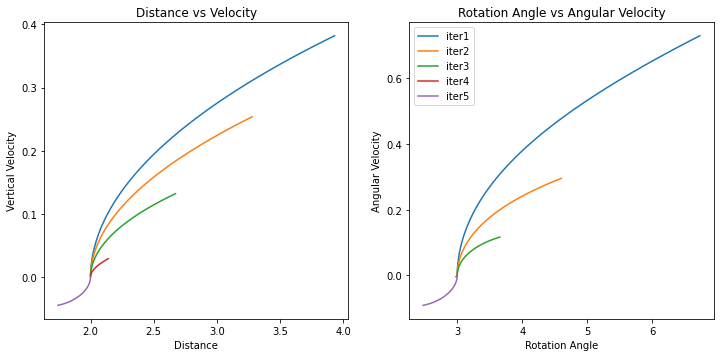

 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
Iteration Numbers 5 to  10
Loss Itertion: 5 = 6.451
Loss Itertion: 6 = 4.494
Loss Itertion: 7 = 3.187
Loss Itertion: 8 = 2.312
Loss Itertion: 9 = 1.688


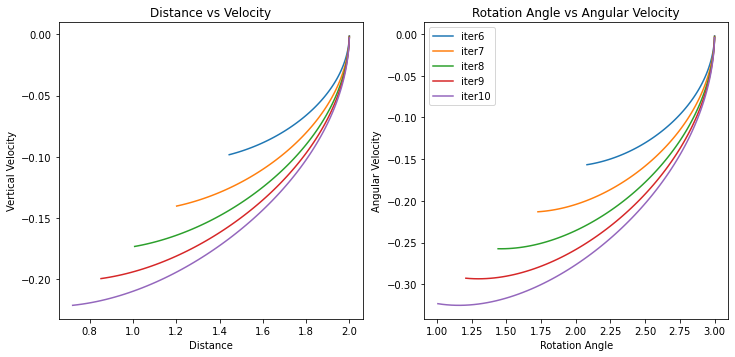

 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
Iteration Numbers 10 to  15
Loss Itertion: 10 = 1.198
Loss Itertion: 11 = 0.812
Loss Itertion: 12 = 0.571
Loss Itertion: 13 = 0.443
Loss Itertion: 14 = 0.374


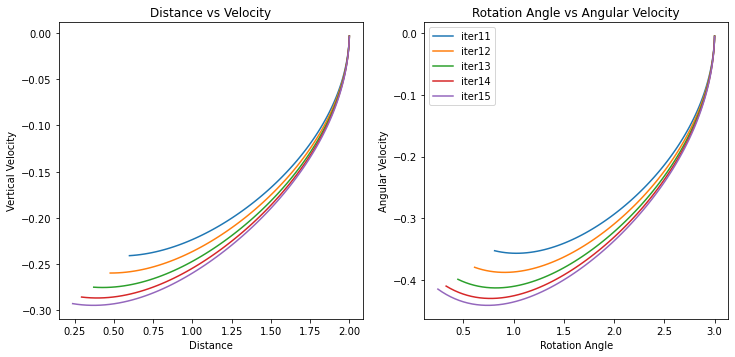

 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
Iteration Numbers 15 to  20
Loss Itertion: 15 = 0.330
Loss Itertion: 16 = 0.295
Loss Itertion: 17 = 0.253
Loss Itertion: 18 = 0.146
Loss Itertion: 19 = 0.085


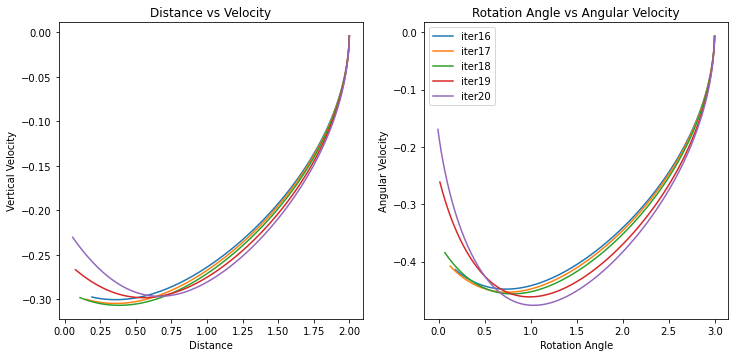

 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
Iteration Numbers 20 to  25
Loss Itertion: 20 = 0.047
Loss Itertion: 21 = 0.030
Loss Itertion: 22 = 0.021
Loss Itertion: 23 = 0.016
Loss Itertion: 24 = 0.012


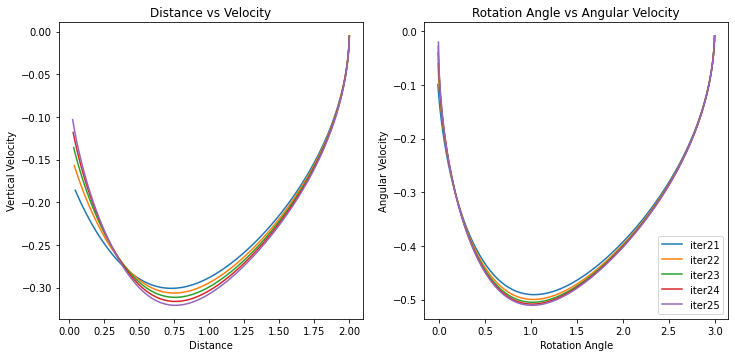

 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
Iteration Numbers 25 to  30
Loss Itertion: 25 = 0.009
Loss Itertion: 26 = 0.007
Loss Itertion: 27 = 0.005
Loss Itertion: 28 = 0.004
Loss Itertion: 29 = 0.003


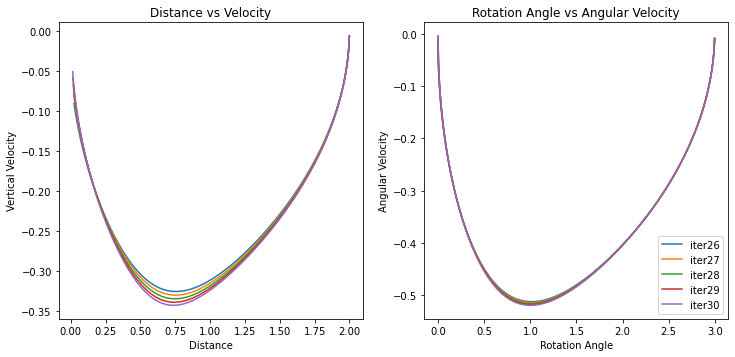

 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
Iteration Numbers 30 to  35
Loss Itertion: 30 = 0.002
Loss Itertion: 31 = 0.002
Loss Itertion: 32 = 0.001
Loss Itertion: 33 = 0.001
Loss Itertion: 34 = 0.000


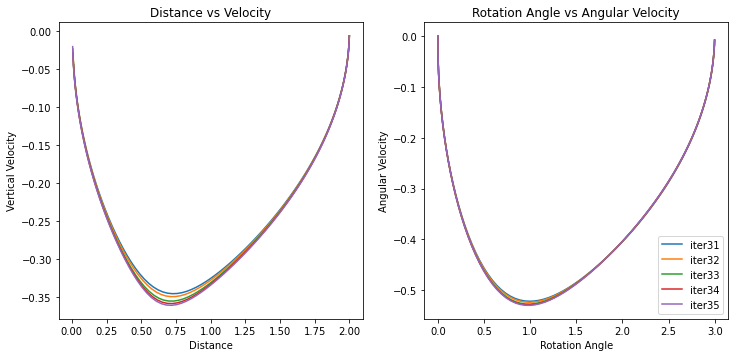

 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
Iteration Numbers 35 to  40
Loss Itertion: 35 = 0.000
Loss Itertion: 36 = 0.000
Loss Itertion: 37 = 0.000
Loss Itertion: 38 = 0.000
Loss Itertion: 39 = 0.000


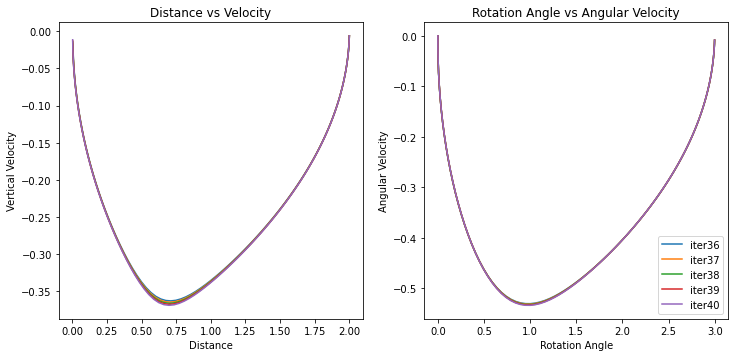

 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
Iteration Numbers 40 to  45
Loss Itertion: 40 = 0.000
Loss Itertion: 41 = 0.000
Loss Itertion: 42 = 0.000
Loss Itertion: 43 = 0.000
Loss Itertion: 44 = 0.000


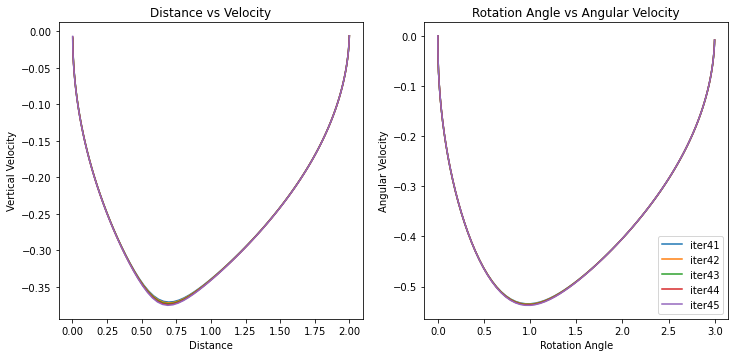

 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
Iteration Numbers 45 to  50
Loss Itertion: 45 = 0.000
Loss Itertion: 46 = 0.000
Loss Itertion: 47 = 0.000
Loss Itertion: 48 = 0.000
Loss Itertion: 49 = 0.000


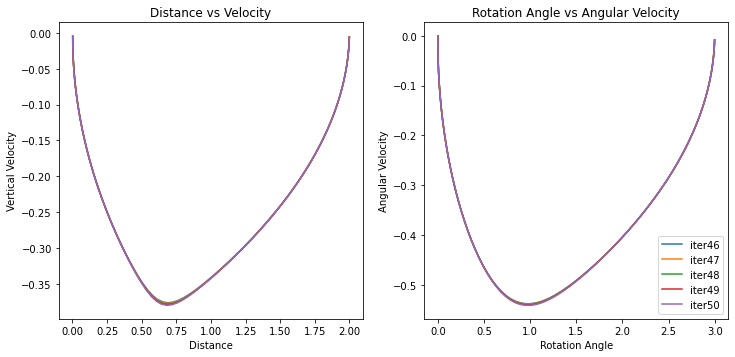

In [12]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 4 # state space dimensions 
dim_hidden = 8  # latent dimensions 
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(50)  # solve the optimization problem. 50 Specifies the number of iterations.